# Recursive Learning Model
Changes from the MELM model:
- Added spline smoothing for the kinematic output (acceleration)
- Added recurrent connections and ensemble to represent it

## 1. Importing Libraries and Preprocessing Data

In [1]:
# Import libraries
import time
import numpy as np
from scipy.interpolate import make_splrep
from scipy.io import loadmat
import nengo
import numpy as np
import pandas as pd
from nengo.ensemble import Ensemble
from nengo.connection import Connection
from nengo.node import Node
import matplotlib.pyplot as plt

First we import the raw data from MT_S2

In [53]:
# Change 'monkey' variable to the desired monkey dataset: MM_S1, MT_S1, MT_S2, MT_S3
monkey = "MT_S1"

# Get Neuron data from .csv files
datafile_path = f"./../../Data Extraction/Extracted Data/{monkey}_raw.csv"
df = pd.read_csv(datafile_path)
headers = df.columns.tolist()
n_neurons = sum("Neuron" in string for string in headers)
neuron_columns = [col for col in df.columns if col.startswith('Neuron')]
activity_matrix = df[neuron_columns]
activity_matrix_t = activity_matrix.transpose().to_numpy()

# Get timestamps
t = df["Timestamp"]
t = t.transpose().to_numpy()

# Get kinematic data from MATLAB files
inp = loadmat(f'/Users/anny/Code/Wat_ai/BCI-Signal-Decoding/Data Extraction/matlab-files/source_data/raw/{monkey}_raw.mat')
x_pos = inp['cont']['pos'][0][0][:,0]
y_pos = inp['cont']['pos'][0][0][:,1]
x_acc = inp['cont']['acc'][0][0][:,0]
y_acc = inp['cont']['acc'][0][0][:,1]

Since the kinematic data is collected from a digital sensor, position can only be represented as a finite number of bits. This means that if we try to take the derivatives of the data to represent velocities/accelerations, we won't get a continuous result. 

Thus, let's try to smooth out our data using B-splines!

In [39]:
len_t = 20000   # number of timesteps 

# Time length in milliseconds
start = time.time()
x_SPL = make_splrep(t[:len_t], x_pos[:len_t], s=0.1, k=4)
end = time.time()
print("X interpolation time: ", end - start)

start = time.time()
y_SPL = make_splrep(t[:len_t], y_pos[:len_t], s=0.1, k=4)
end = time.time()
print("Y interpolation time: ", end - start)

d1_x = x_SPL.derivative(1) # X_Velocity
d2_x = d1_x.derivative(1) # X_Acceleration

d1_y = y_SPL.derivative(1) # Y_Velocity
d2_y = d1_y.derivative(1) # Y_Acceleration

acceleration_matrix_t = [d2_x(t[:len_t])/np.max(np.abs(d2_x(t[:len_t]))), 
                         d2_y(t[:len_t])/np.max(np.abs(d2_y(t[:len_t])))]

X interpolation time:  14.804298877716064
Y interpolation time:  24.680959939956665


Now visualizing the results of interpolation

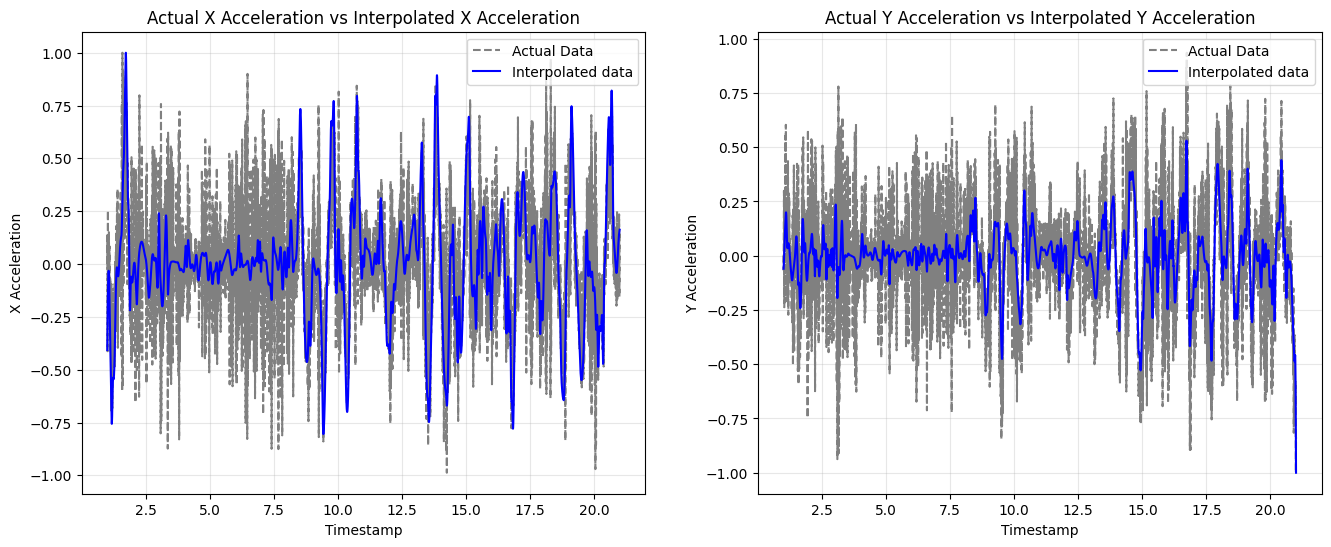

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))


# x acceleration
axes[0].plot(t[:len_t], x_acc[:len_t]/np.max(np.abs(x_acc[:len_t])), label="Actual Data", color='gray', linestyle='--')
axes[0].plot(t[:len_t], acceleration_matrix_t[0], label="Interpolated data", color='blue', linestyle='-')
axes[0].set_xlabel("Timestamp")
axes[0].set_ylabel("X Acceleration")
axes[0].set_title("Actual X Acceleration vs Interpolated X Acceleration")
axes[0].legend(loc="upper right")
axes[0].grid(alpha=0.3)

# y acceleration
axes[1].plot(t[:len_t], y_acc[:len_t]/np.max(np.abs(y_acc[:len_t])), label="Actual Data", color='gray', linestyle='--')
axes[1].plot(t[:len_t], acceleration_matrix_t[1], label="Interpolated data", color='blue', linestyle='-')
axes[1].set_xlabel("Timestamp")
axes[1].set_ylabel("Y Acceleration")
axes[1].set_title("Actual Y Acceleration vs Interpolated Y Acceleration")
axes[1].legend(loc="upper right")
axes[1].grid(alpha=0.3)

# Show the plot
plt.show()

In [ ]:
# # doing the same thing, but for positions
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# # x 
# axes[0].plot(t[:len_t], x_pos[:len_t]/np.max(np.abs(x_pos[:len_t])), "k", label="X Position (Dataset)")
# axes[0].plot(t[:len_t], x_SPL(t[:len_t])/np.max(np.abs((t[:len_t]))), "r:", label="X Position (Splines)")
# axes[0].set_xlabel("Timestamp")
# axes[0].set_ylabel("X Position")
# axes[0].set_title("Actual X Position vs Interpolated X Position")
# axes[0].legend(loc="upper right")
# axes[0].grid(alpha=0.3)

# # y 
# axes[1].plot(t[:len_t], y_pos[:len_t]/np.max(np.abs(y_pos[:len_t])), "k", label="Y Position (Dataset)")
# axes[1].plot(t[:len_t], y_SPL(t[:len_t])/np.max(np.abs(y_SPL(t[:len_t]))), "r:", label="Y Position (Splines)")
# axes[1].set_xlabel("Timestamp")
# axes[1].set_ylabel("Y Acceleration")
# axes[1].set_title("Actual Y Acceleration vs Interpolated Y Acceleration")
# axes[1].legend(loc="upper right")
# axes[1].grid(alpha=0.3)

# # Show the plot
# plt.show()

## 2. Building the model

Setting the model parameters

In [63]:
spikes = activity_matrix_t
scalar = np.max(acceleration_matrix_t)
target_out = acceleration_matrix_t/scalar 

# Model Information
dt = 0.001
dti = 1/dt
spikes = spikes*dti

# Model Parameters
n_ensemble_neurons = 3000
ensemble_radius = 1     # ? Represents the range of values for the neurons?
ensemble_synapse = 0.025
probe_synapse = 0.01
running_time = 19 # How long the model should run for, should be < len_t or else it will go out of bounds
training_time = 0.8*running_time # WHen does the model stop learning


Building the nengo network

In [64]:
with nengo.Network() as model:
    in_node = nengo.Node(lambda t: spikes[:,int(t / dt) - 1])
    
    target_node = nengo.Node(lambda t: target_out[:,int(t / dt) - 1]) # expected kinematic output
    inhib_node = nengo.Node(output=lambda t: t >= training_time)

    rep_ens = nengo.Ensemble(n_ensemble_neurons, n_neurons, ensemble_radius)
    recurr_ens = nengo.Ensemble(n_ensemble_neurons, n_neurons, ensemble_radius)
    out_ens = nengo.Ensemble(n_ensemble_neurons, 2, ensemble_radius)
    err_ens = nengo.Ensemble(n_ensemble_neurons, 2, ensemble_radius)

    in_rep_con = nengo.Connection(in_node, rep_ens, ensemble_synapse) # Acts as a low-pass for the spike input
    in_rec_con = nengo.Connection(in_node, recurr_ens, ensemble_synapse)
    rec_rec_con = nengo.Connection(recurr_ens, recurr_ens, synapse=ensemble_synapse, transform=1) # putting transform = 1 as a placeholder (?)
    rec_out_con = nengo.Connection(recurr_ens, out_ens, function=lambda x: [0, 0], learning_rule_type=nengo.PES(learning_rate=2e-4))
    rep_out_con = nengo.Connection(rep_ens, out_ens, function=lambda x: [0, 0], learning_rule_type=nengo.PES(learning_rate=2e-4))
    out_err_con = nengo.Connection(out_ens, err_ens)
    tar_err_con = nengo.Connection(target_node, err_ens, transform=-1)
    err_rep_lrn_con = nengo.Connection(err_ens, rep_out_con.learning_rule) # Connects error ensemble value to learning rule -- analogous to how backprop uses error to follow stochastic gradient in training
    err_rec_lrn_con = nengo.Connection(err_ens, rec_out_con.learning_rule)
    inhib_lrn_con = nengo.Connection(inhib_node, err_ens.neurons, transform=-20 * np.ones((err_ens.n_neurons, 1))) # Inhibit error ensemble once training is done to prevent weight changes after training_time

    p_out = nengo.Probe(out_ens, synapse=probe_synapse)
    p_err = nengo.Probe(err_ens, synapse=probe_synapse)




Model architecture

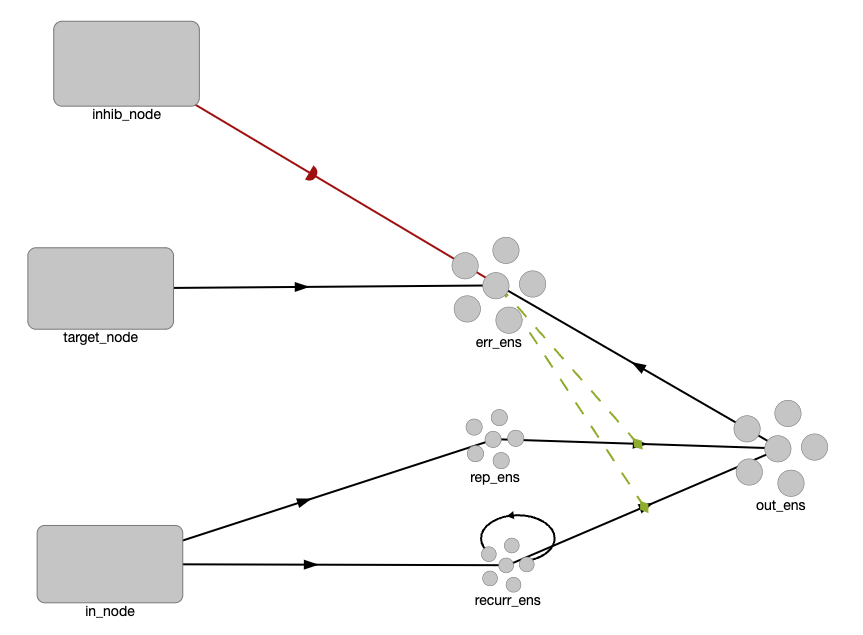

## 3. Visualizing results


In [66]:
with nengo.Simulator(model, dt=dt, seed=0) as sim:
    sim.run(running_time)

Build finished in 0:00:09.                                                      
Simulation finished in 0:00:21.                                                 


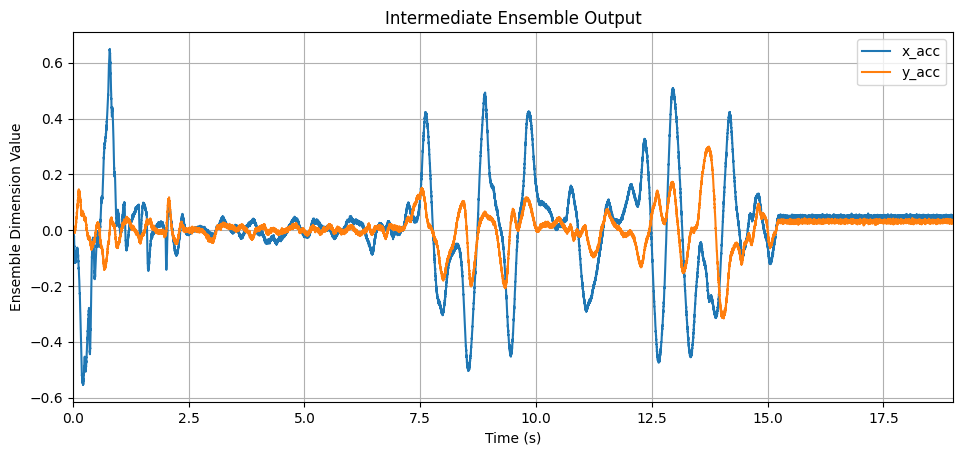

In [67]:
# For the outputs
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_out])
pl.set_title("Intermediate Ensemble Output")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_acc", "y_acc"])
pl.grid()

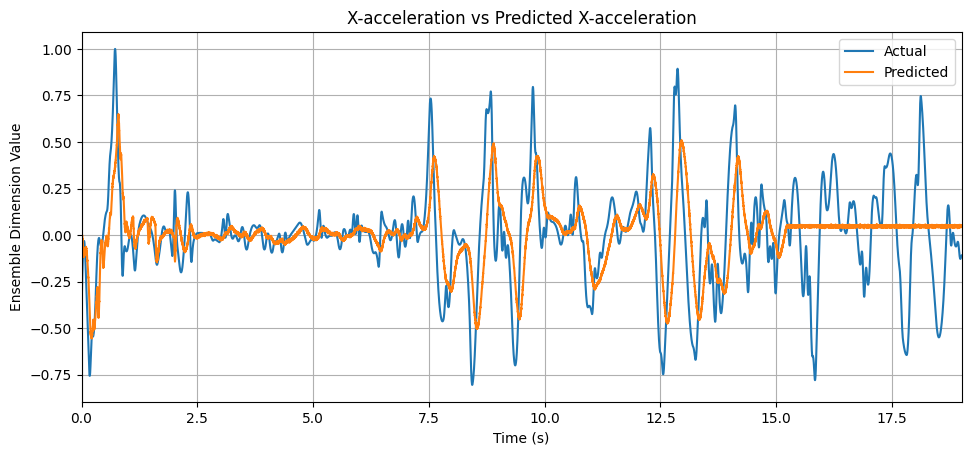

In [68]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), target_out[0, 0:len(sim.trange())])
pl.plot(sim.trange(), sim.data[p_out][:, 0])
pl.set_title("X-acceleration vs Predicted X-acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Actual", "Predicted"])
pl.grid()

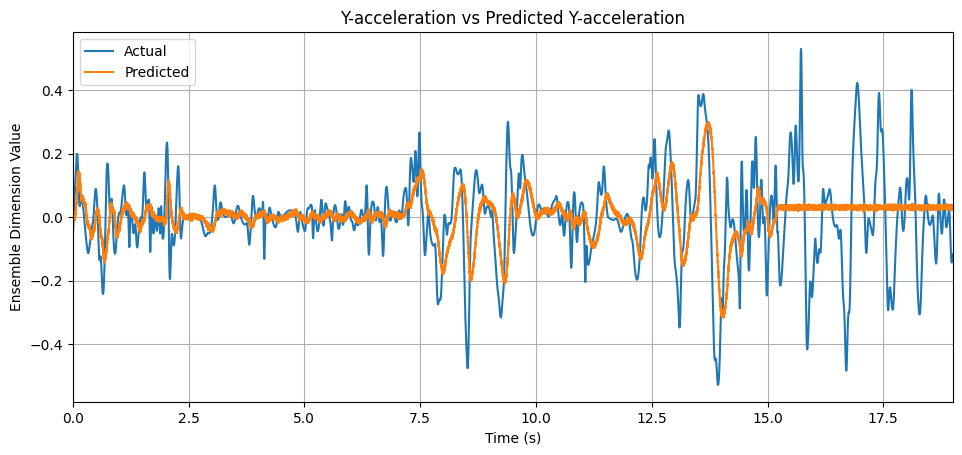

In [69]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), target_out[1, 0:len(sim.trange())])
pl.plot(sim.trange(), sim.data[p_out][:, 1])
pl.set_title("Y-acceleration vs Predicted Y-acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Actual", "Predicted"])
pl.grid()

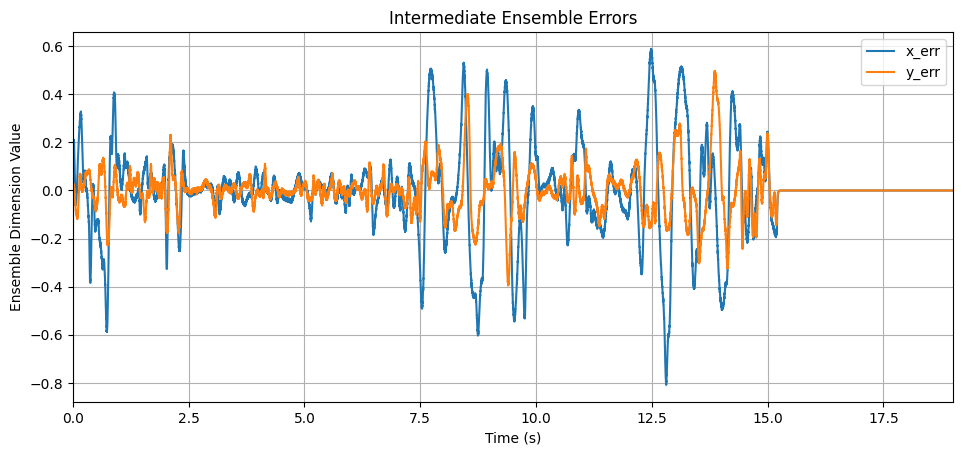

In [70]:
# For the errors
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_err])
pl.set_title("Intermediate Ensemble Errors")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_err", "y_err"])
pl.grid()

## 4. Evaluation

In [19]:
def GetErrors(truth, predicted):
    # ax := ground truth x acceleration, ay := ground truth y acceleration
    # sim.data[p_a] := 2-dimensional output with 0th dimension corresponding to x and 1st dimension corresponding to y
    e_mae = np.sum(np.abs(truth - predicted)) / truth.shape[0]
    e_rmse = np.sqrt(np.sum(np.power(truth - predicted, 2)) / truth.shape[0])
    print("Mean Absolute Error: " + str(e_mae))
    print("Root Mean_Squared Error: " + str(e_rmse))

In [20]:
# X-Acceleration Error
print("X-Acceleration Error")
GetErrors(target_out[0, 0:len(sim.trange())], sim.data[p_out][:, 0])
print("")

# Y-Acceleration Error
print("Y-Acceleration Error")
GetErrors(target_out[1, 0:len(sim.trange())], sim.data[p_out][:, 1])
print("")

X-Acceleration Error
Mean Absolute Error: 0.1819049608312321
Root Mean_Squared Error: 0.26295077147510354

Y-Acceleration Error
Mean Absolute Error: 0.09152055212909987
Root Mean_Squared Error: 0.13467107117499058

